In [1]:
import re
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting

/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# importing rmaps

In [2]:
network_interest = "DMN"
connectivity_maps = glob.glob("rest/rmap_seeds/*sub*_"+network_interest+".nii.gz")
len(connectivity_maps)

112

# import csv file 

In [3]:
#load the csv files
cimaq_diagnostic = pd.read_csv('36448_diagnostic_clinique.tsv', sep = '\t')
cimaq_diagnostic
print(set(cimaq_diagnostic['36448_diagnostic_clinique'].values))

#Rename the columns
cimaq_diagnostic = cimaq_diagnostic[['CandID','36448_diagnostic_clinique','Candidate_Age']]
cimaq_diagnostic.rename(columns = {"CandID":"subID","36448_diagnostic_clinique":"diagnostic","Candidate Age":"Age" },inplace=True)

#drop the rows that have nan
cimaq_diagnostic.dropna(inplace=True)

#drop the SCD and MCI subjects
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "troubles_subjectifs_de_cognition" ]
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "trouble_cognitif_léger_précoce" ]
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "trouble_cognitif_léger_tardif" ]

#Get the subject IDs from the the rmaps
subjectID_set = set([sub.split("sub")[1].split("_")[0] for sub in connectivity_maps])
                    
#drop the subjects from csv if rmaps are not present
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]                   
                    
print(cimaq_diagnostic.shape)
cimaq_diagnostic.head()

{nan, 'trouble_cognitif_léger_précoce', 'troubles_subjectifs_de_cognition', 'démence_de_type_alzheimer-légère', 'trouble_cognitif_léger_tardif', 'cognitivement_sain_(cs)'}
(34, 3)


,subID,diagnostic,Candidate_Age
3,878652.0,démence_de_type_alzheimer-légère,78.6
4,318809.0,cognitivement_sain_(cs),70.9
11,437101.0,cognitivement_sain_(cs),74.5
12,324734.0,cognitivement_sain_(cs),89.3
21,164965.0,cognitivement_sain_(cs),66.3


In [4]:
#cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] == "démence_de_type_alzheimer-légère" ]
cimaq_diagnostic.head()

,subID,diagnostic,Candidate_Age
3,878652.0,démence_de_type_alzheimer-légère,78.6
4,318809.0,cognitivement_sain_(cs),70.9
11,437101.0,cognitivement_sain_(cs),74.5
12,324734.0,cognitivement_sain_(cs),89.3
21,164965.0,cognitivement_sain_(cs),66.3


# create design matrix

In [5]:

cimaq_diagnostic["MCI"] = 0
cimaq_diagnostic["SCD"] = 0
cimaq_diagnostic["CN"] = 0
cimaq_diagnostic["AD"] = 0

for i,r in cimaq_diagnostic.iterrows():
    
    #print(i)
#     if(r["diagnostic"] == "troubles_subjectifs_de_cognition" ):
#         cimaq_diagnostic.loc[i,"SCD"] = 1

    if(r["diagnostic"] == "cognitivement_sain_(cs)"):
        cimaq_diagnostic.loc[i,"CN"] = 1          

#     if("trouble_cognitif_léger" in r["diagnostic"] ):
#         cimaq_diagnostic.loc[i,"MCI"] = 1
 
    if("démence_de_type_alzheimer-légère" == r["diagnostic"] ):
        cimaq_diagnostic.loc[i,"AD"] = 1
 
        


    cimaq_diagnostic.loc[i,"subID"] = str(r["subID"]).split(".")[0]
    

# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]
# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
cimaq_diagnostic.head()

,subID,diagnostic,Candidate_Age,MCI,SCD,CN,AD
3,878652,démence_de_type_alzheimer-légère,78.6,0,0,0,1
4,318809,cognitivement_sain_(cs),70.9,0,0,1,0
11,437101,cognitivement_sain_(cs),74.5,0,0,1,0
12,324734,cognitivement_sain_(cs),89.3,0,0,1,0
21,164965,cognitivement_sain_(cs),66.3,0,0,1,0


In [6]:
set(cimaq_diagnostic['diagnostic'].values)

{'cognitivement_sain_(cs)', 'démence_de_type_alzheimer-légère'}

In [7]:
design_matrix = cimaq_diagnostic[["AD","CN"]]
design_matrix.shape

(34, 2)

# perform  t-test

In [8]:
#take the rmaps that are in the csv
second_level_input = []
for i in connectivity_maps:
    sub = re.search("\d\d\d\d\d\d",i)
    subid = sub.group(0)
    if(subid in set(cimaq_diagnostic["subID"].values)):        
        second_level_input.append(i)


In [9]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
z_score = second_level_model.compute_contrast(second_level_contrast = [-1,1])

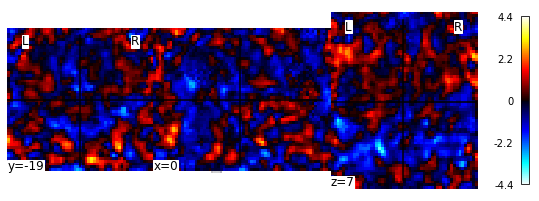

In [10]:
plotting.plot_stat_map(z_score)

/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:63: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  .format(DEFAULT_CUT_COORDS))
/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


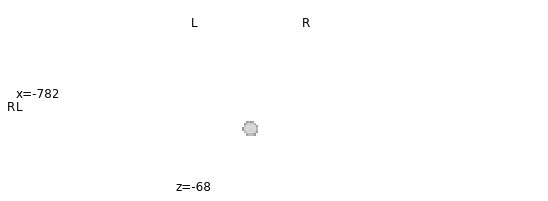

In [11]:
thresholded_map, threshold = map_threshold(z_score, alpha=0.9, height_control='fdr')
plotting.plot_stat_map(thresholded_map)

# F-test

In [12]:
#second_level_model2 = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
#p_map = second_level_model2.compute_contrast(second_level_contrast = [1,1,1], second_level_stat_type = "F")

In [13]:
#plotting.view_img(p_map)